Before any assessment, we need to import the necessary python libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB

from scipy import stats
import statsmodels.api as sm

np.random.seed(42)

The data we are going to look at today is a diabetes dataset with tabular features of patient condition with diabetic index as target variable. We looked at it closer using dataframe head() method.

In [ ]:
data = load_diabetes(as_frame=True)
df = data.frame

X = df.drop(columns="target")
y = df["target"]

In [ ]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0



# Hypothesis Testing (using Pearson Correlation)

Hypothesis testing, in the context of ML, helps us understand the internal relationships between data features. This is useful for statistically assessing and identifying relevant features.


H0 (Null Hypothesis): Feature has no relationship with target

H1: Feature has a statistically significant relationship



---

Interpretation:
- r value: correlation coefficient (magnitude and direction)
- p-value <= 0.05 (Statistically significant feature)
- p-value > 0.05 (Statistically insignificant feature)


Considerations:
- Low p-value ≠ large effect
- Statistical significance ≠ practical usefulness

In [ ]:
for col in ["bmi", "bp", "s5", "sex"]:
    r, p = stats.pearsonr(X[col], y)
    print(f"{col:>4} | r = {r:.3f}, p-value = {p:.4e}")

 bmi | r = 0.586, p-value = 3.4660e-42
  bp | r = 0.441, p-value = 1.6494e-22
  s5 | r = 0.566, p-value = 8.8265e-39
 sex | r = 0.043, p-value = 3.6643e-01



**Observation:**

We observed that most of selected features have mild positive correlation **(r value)** with target, meaning that target value increases and decrease as these features do.



Also, most of these features have a p-value < 0.05, making them statistically significant.

Only exception is sex feature that has almost no correlation and no statistical significance with target.


# Train-Test Split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Bias–Variance Analysis (Learning Curves)

This step is useful to check model and data compatibility via bias and variance.

Bias: When model isn't able to capture the complexity of the data. Irrespective of training or testing, model has high error.

Variance: When model conplexity is too high for the data. This results in overfit, meaning low error with training but very high error with test data.


Interpretation:
- High bias → both errors high & close
- High variance → low train error, high val error

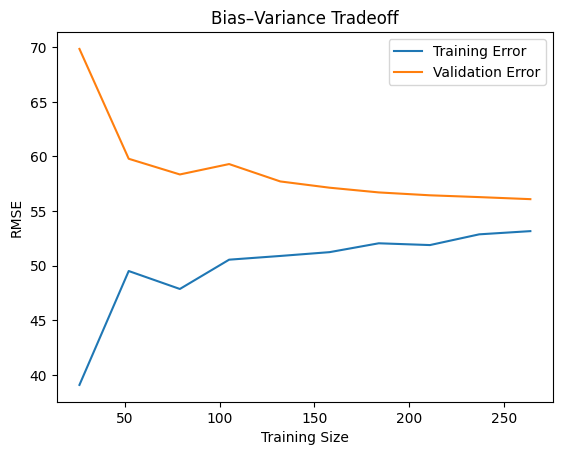

In [ ]:
model = LinearRegression()

train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_train,
    y_train,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

plt.figure()
plt.plot(train_sizes, train_rmse, label="Training Error")
plt.plot(train_sizes, val_rmse, label="Validation Error")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.title("Bias–Variance Tradeoff")
plt.legend()
plt.show()


**Observation:**

Both training and test RMSE (root mean squared error) stagnate to a substantially high error value, suggesting Bias.

# Model Training

In [ ]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")


Model Performance:
RMSE: 55.73
R²:   0.438


# Confidence Intervals (Coefficients)

For each of the parameter in data, we compute/ estimate the coefficient.
If we were to repeat the data collection process many times and compute 90% CI every time, then ~95% of these intervals would contain the true parameter value.

CI answers that, **how much would this estimate change if we repeated the experiment?**

This gives the reliability of coefficient estimation.



---




Interpretation:
- If CI crosses zero → coefficient is not statistically reliable
- Strong effect = narrow CI far from zero


In [ ]:
X_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_sm).fit()

print("\n--- Coefficient Confidence Intervals (95%) ---")
print(ols_model.conf_int())


--- Coefficient Confidence Intervals (95%) ---
                 0            1
const   145.716758   157.613593
age     -93.198945   188.698306
sex    -381.208811  -102.773004
bmi     376.449946   687.492180
bp      233.893921   529.231803
s1    -1827.682231    -9.323579
s2     -225.293691  1241.809256
s3     -352.291890   586.192219
s4     -105.551045   644.535651
s5      308.826141  1082.790093
s6     -124.881024   177.530188


**Observation:**

Features with reliable coefficient estimation: const, sex, bmi, bp, s1 and s5

const being the most reliable of the lot.

# Prediction Uncertainty (Bootstrap)

Boostraping means to resample a subset of the same data in random fashion to assess the prediction uncertainty of model.

In [ ]:
n_bootstraps = 1000
predictions = []

for _ in range(n_bootstraps):
    X_bs, y_bs = resample(X_train, y_train)
    model_bs = Ridge(alpha=1.0)
    model_bs.fit(X_bs, y_bs)
    predictions.append(model_bs.predict(X_test))


In [ ]:
predictions = np.array(predictions)

lower = np.percentile(predictions, 2.5, axis=0)
upper = np.percentile(predictions, 97.5, axis=0)

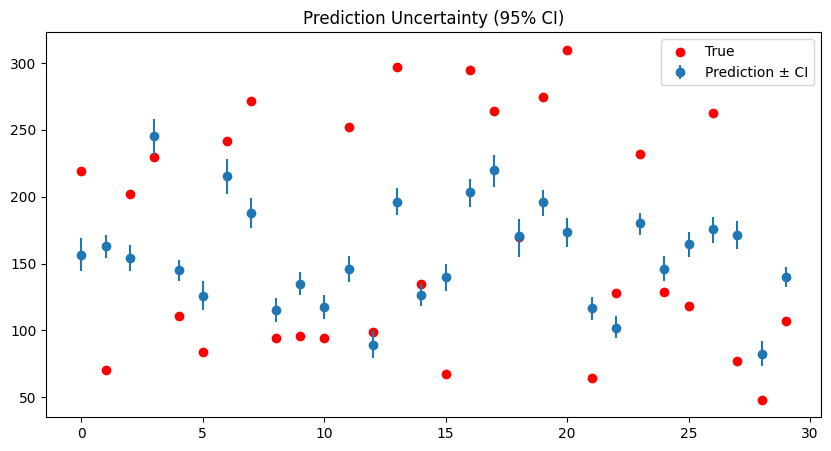

'\nThis captures:\n- Model uncertainty\n- Data instability\n'

In [ ]:
n_bootstraps = 1000
predictions = []

for _ in range(n_bootstraps):
    X_bs, y_bs = resample(X_train, y_train)
    model_bs = Ridge(alpha=1.0)
    model_bs.fit(X_bs, y_bs)
    predictions.append(model_bs.predict(X_test))

predictions = np.array(predictions)

lower = np.percentile(predictions, 2.5, axis=0)
upper = np.percentile(predictions, 97.5, axis=0)

# Plot uncertainty for first 30 samples
plt.figure(figsize=(10, 5))
plt.errorbar(
    range(30),
    y_pred[:30],
    yerr=[y_pred[:30] - lower[:30], upper[:30] - y_pred[:30]],
    fmt="o",
    label="Prediction ± CI"
)
plt.scatter(range(30), y_test[:30], color="red", label="True")
plt.title("Prediction Uncertainty (95% CI)")
plt.legend()
plt.show()





This captures:
- Model uncertainty
- Data instability

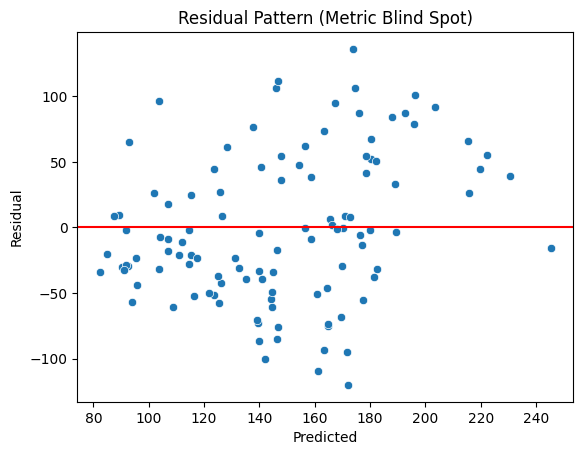


RMSE by BMI group:
bmi_group
(-0.0913, -0.0418]    45.002646
(-0.0418, -0.0181]    49.609578
(-0.0181, 0.0272]     66.678913
(0.0272, 0.171]       60.655790
dtype: float64

KEY TAKEAWAYS:

1. Hypothesis testing tells you WHAT is statistically real,
   not whether it is useful.

2. Bias–variance analysis explains WHY models underperform.

3. Confidence intervals tell you HOW CERTAIN parameters are.

4. Error bars show whether predictions are trustworthy.

5. Metrics lie when:
   - Residuals are structured
   - Data is imbalanced
   - Subgroups behave differently



/tmp/ipython-input-1977233505.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_rmse = df_test.groupby("bmi_group").apply(
/tmp/ipython-input-1977233505.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_rmse = df_test.groupby("bmi_group").apply(


In [ ]:

# =========================
# 9. When Metrics Lie
# =========================

"""
CASE 1: High R² but biased residuals
"""

residuals = y_test - y_pred

plt.figure()
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="red")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual Pattern (Metric Blind Spot)")
plt.show()

"""
Even with good RMSE/R²:
- Non-random residuals → model misspecification
"""

"""
CASE 2: Average metrics hide subgroup errors
"""

df_test = X_test.copy()
df_test["target"] = y_test
df_test["pred"] = y_pred

df_test["bmi_group"] = pd.qcut(df_test["bmi"], q=4)

group_rmse = df_test.groupby("bmi_group").apply(
    lambda g: np.sqrt(mean_squared_error(g["target"], g["pred"]))
)

print("\nRMSE by BMI group:")
print(group_rmse)

"""
Metric lies when:
- Minority regimes are poorly predicted
- Aggregated score hides failure modes
"""

# =========================
# 10. Final Takeaways
# =========================
print("""
KEY TAKEAWAYS:

1. Hypothesis testing tells you WHAT is statistically real,
   not whether it is useful.

2. Bias–variance analysis explains WHY models underperform.

3. Confidence intervals tell you HOW CERTAIN parameters are.

4. Error bars show whether predictions are trustworthy.

5. Metrics lie when:
   - Residuals are structured
   - Data is imbalanced
   - Subgroups behave differently
""")